In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(42)
import random

# Classifying objects

In the following, we will use the old-school CIFAR-10 dataset that contains low-resolution pictures of objects of 10 categories. This - and other - dataset is available as part of the `torchvision` package, which you should install.

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [4]:
from torchvision import datasets, transforms, utils
# where to put the data
data_path = './'

# this constructs a CIFAR10 dataset, selects the training part of it, 
# downloads it if necessary, and adds additional transforms that we 
# will need to convert each image to a pytorch tensor AND to provide
# a nice conversion of the RGB images into greyscale
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

C:\Users\DL_Simulcom2\AppData\Roaming\Python\Python38\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\DL_Simulcom2\AppData\Roaming\Python\Python38\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


1.8%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

4.9%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

8.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

11.0%IOPub me

This has now downloaded the images if not already done so - you will notice that this is quite a "hefty" dataset already at 170MB. Now let's download our validation set or test set.

In [5]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [6]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [7]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

## Part1 Pytorch CNN level 1

In [8]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(F.relu(self.conv1(x)), 2)
        out = F.max_pool2d(F.relu(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [36]:
import datetime 

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader,val_loader, iter_num):
    train_acc_ep =np.zeros(n_epochs)
    val_acc_ep= np.zeros(n_epochs)
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        correct = 0
        total = 0
        for imgs, labels in train_loader:
            # put the data onto the correct pytorch calculation device
            imgs=  imgs.to(device =device)
            labels = labels.to (device = device)
            # put a batch through the model
            outputs = model(imgs)
            # determine the loss
            loss = loss_fn(outputs, labels)
            # zero the gradients and determine backpropagation
            optimizer.zero_grad()
            loss.backward()

           # do one step of optimization
            optimizer.step()
            # keep track of the loss
            loss_train += loss.item()
            #keep track of accuracy
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
        
        
        train_acc_ep[epoch-1]=100.*correct/total
            

        if epoch == 1 or epoch % 10 == 0:
            print('{} Random Seed Iteration Number {} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), iter_num+1, epoch,
                loss_train / len(train_loader)))
        
        with torch.no_grad():
            for imgs, labels in val_loader:
                    imgs = imgs.to(device=device)
                    labels = labels.to(device=device)
                    outputs = model(imgs)
                    _, predicted = torch.max(outputs, dim=1)
                    total += labels.shape[0]
                    correct += int((predicted == labels).sum())
        
        val_acc_ep[epoch-1]=100.*correct/total
        
        
    return train_acc_ep, val_acc_ep

In [37]:
device = (torch.device('cuda')if torch.cuda.is_available() 
    else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


Define 20 different seeds and train this network for 100 epochs with a batch size of
64, ADAM optimizer (learning rate = 1e-4), tracking training and validation accuracy
in EACH epoch.


In [38]:
def validate(model, train_loader, val_loader):
    acc =[]
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        
        acc.append(correct / total)

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        
    return acc[0], acc[1] 

In [40]:
train_acc_all = np.zeros(20)
val_acc_all= np.zeros(20)
train_acc_epoch = np.zeros([20,100])
val_acc_epoch = np.zeros([20,100])
for i in range(20):
    
    seed_int =random.randint(0, 1000) # creating random seed values for the  different datasets
    torch.manual_seed(seed_int)
    train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)
    val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

    # get the model and put it onto the proper device
    model = Net().to(device=device)
    # standard optimizer 
    optimizer = optim.Adam(model.parameters(), lr=1e-4) 
    # classification loss
    loss_fn = nn.CrossEntropyLoss()

    # go for 100 epochs
    train_acc_epoch [i,:], val_acc_epoch[i,:] = training_loop(n_epochs = 100, optimizer = optimizer, model = model, loss_fn = loss_fn, train_loader = train_loader, val_loader = val_loader,iter_num =i )
    
    train_acc_all[i], val_acc_all[i]=validate(model, train_loader, val_loader)


2022-11-20 22:45:13.563556 Random Seed Iteration Number 1 Epoch 1, Training loss 0.6167402774285359
2022-11-20 22:45:17.081625 Random Seed Iteration Number 1 Epoch 10, Training loss 0.33083745913141094
2022-11-20 22:45:20.874183 Random Seed Iteration Number 1 Epoch 20, Training loss 0.3032182773966698
2022-11-20 22:45:24.614562 Random Seed Iteration Number 1 Epoch 30, Training loss 0.2873375264892153
2022-11-20 22:45:28.398801 Random Seed Iteration Number 1 Epoch 40, Training loss 0.2701356874150076
2022-11-20 22:45:32.175669 Random Seed Iteration Number 1 Epoch 50, Training loss 0.2562243304434855
2022-11-20 22:45:35.910787 Random Seed Iteration Number 1 Epoch 60, Training loss 0.24414922401403924
2022-11-20 22:45:39.693182 Random Seed Iteration Number 1 Epoch 70, Training loss 0.23034080991129965
2022-11-20 22:45:43.435427 Random Seed Iteration Number 1 Epoch 80, Training loss 0.21922440437754248
2022-11-20 22:45:47.215167 Random Seed Iteration Number 1 Epoch 90, Training loss 0.2096

2022-11-20 22:49:49.365758 Random Seed Iteration Number 8 Epoch 20, Training loss 0.2927847694439493
2022-11-20 22:49:53.081610 Random Seed Iteration Number 8 Epoch 30, Training loss 0.2680590826614647
2022-11-20 22:49:56.771721 Random Seed Iteration Number 8 Epoch 40, Training loss 0.2515104725292534
2022-11-20 22:50:00.474309 Random Seed Iteration Number 8 Epoch 50, Training loss 0.2395857288294537
2022-11-20 22:50:04.299928 Random Seed Iteration Number 8 Epoch 60, Training loss 0.2278614057951672
2022-11-20 22:50:08.560083 Random Seed Iteration Number 8 Epoch 70, Training loss 0.2192932339800391
2022-11-20 22:50:12.600924 Random Seed Iteration Number 8 Epoch 80, Training loss 0.20604728632102345
2022-11-20 22:50:16.338641 Random Seed Iteration Number 8 Epoch 90, Training loss 0.1979717495524959
2022-11-20 22:50:20.224823 Random Seed Iteration Number 8 Epoch 100, Training loss 0.1883689010409033
Accuracy train: 0.93
Accuracy val: 0.89
2022-11-20 22:50:20.767911 Random Seed Iteration 

2022-11-20 22:54:27.181013 Random Seed Iteration Number 15 Epoch 30, Training loss 0.2836975717240838
2022-11-20 22:54:31.117852 Random Seed Iteration Number 15 Epoch 40, Training loss 0.26835391732158176
2022-11-20 22:54:34.933861 Random Seed Iteration Number 15 Epoch 50, Training loss 0.2564793036432023
2022-11-20 22:54:38.585889 Random Seed Iteration Number 15 Epoch 60, Training loss 0.2397519308765223
2022-11-20 22:54:42.263241 Random Seed Iteration Number 15 Epoch 70, Training loss 0.23045897730596507
2022-11-20 22:54:45.934418 Random Seed Iteration Number 15 Epoch 80, Training loss 0.21544745341417895
2022-11-20 22:54:49.657715 Random Seed Iteration Number 15 Epoch 90, Training loss 0.20617019024434363
2022-11-20 22:54:53.334449 Random Seed Iteration Number 15 Epoch 100, Training loss 0.1982606304868771
Accuracy train: 0.92
Accuracy val: 0.90
2022-11-20 22:54:53.873004 Random Seed Iteration Number 16 Epoch 1, Training loss 0.619248418861134
2022-11-20 22:54:57.200418 Random Seed 

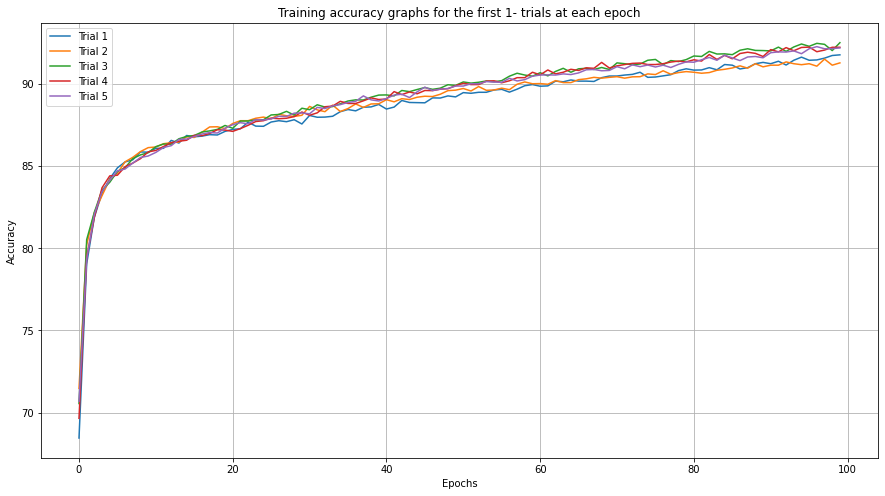

In [54]:
plt.subplots(figsize=(15, 8))
for i in range(5):
    plt.plot(train_acc_epoch[i])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Trial 1', 'Trial 2','Trial 3', 'Trial 4', 'Trial 5'])
plt.title('Training accuracy graphs for the first 1- trials at each epoch')
plt.grid()

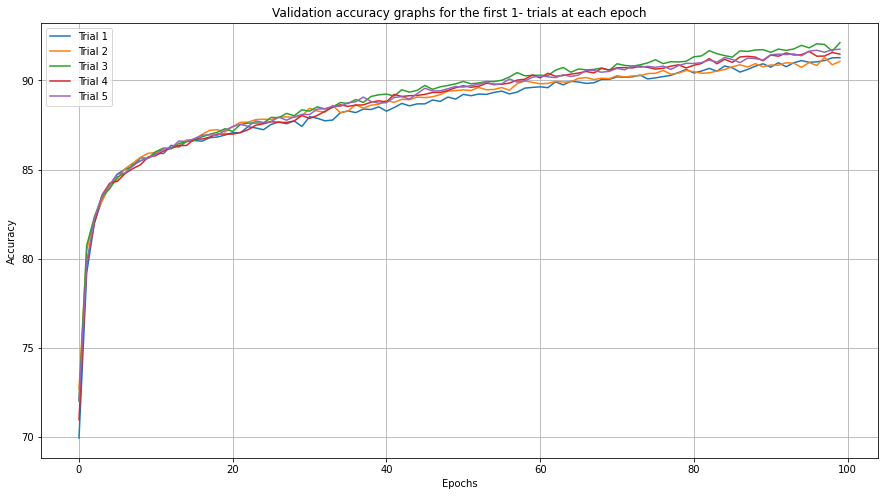

In [55]:
plt.subplots(figsize=(15, 8))
for i in range(5):
    plt.plot(val_acc_epoch[i])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Trial 1', 'Trial 2','Trial 3', 'Trial 4', 'Trial 5'])
plt.title('Validation accuracy graphs for the first 1- trials at each epoch')
plt.grid()

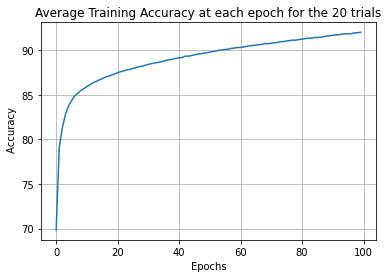

In [56]:
plt.plot(np.mean(train_acc_epoch, axis=0)) #taking the mean of each column -- average accuraccu at each epock for the 20 trials
plt.xlabel('Epochs')
plt.ylabel(' Accuracy')
plt.title('Average Training Accuracy at each epoch for the 20 trials')
plt.grid()

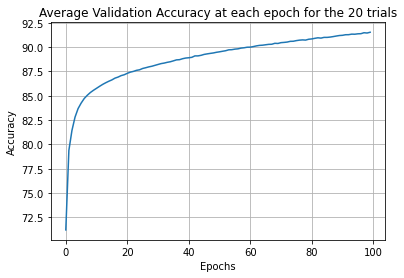

In [58]:
plt.plot(np.mean(val_acc_epoch, axis=0)) #taking the mean of each column -- average accuraccu at each epock for the 20 trials
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Average Validation Accuracy at each epoch for the 20 trials')
plt.grid()

In [13]:
train_acc

array([0.917 , 0.914 , 0.9361, 0.9171, 0.9252, 0.919 , 0.916 , 0.9249,
       0.9114, 0.9266, 0.917 , 0.9157, 0.9251, 0.9185, 0.9175, 0.9154,
       0.9253, 0.9232, 0.9146, 0.9151])

In [14]:
val_acc

array([0.896 , 0.8945, 0.893 , 0.887 , 0.8915, 0.8895, 0.8875, 0.894 ,
       0.8885, 0.8955, 0.889 , 0.8935, 0.89  , 0.8825, 0.893 , 0.8905,
       0.887 , 0.8785, 0.8895, 0.893 ])

In [41]:
models_collection = []
for i in range(20):
    
    seed_int =random.randint(0, 1000) # creating random seed values for the  different datasets
    torch.manual_seed(seed_int)
    train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

    # get the model and put it onto the proper device
    model = Net().to(device=device)
    # standard optimizer 
    optimizer = optim.Adam(model.parameters(), lr=1e-4) 
    # classification loss
    loss_fn = nn.CrossEntropyLoss()

    # go for 100 epochs
    training_loop(n_epochs = 100, optimizer = optimizer, model = model, loss_fn = loss_fn, train_loader = train_loader,iter_num =i )
    

    models_collection.append(model)

2022-11-20 21:35:45.657395 Random Seed Iteration Number 1 Epoch 1, Training loss 0.5906210936558475
2022-11-20 21:36:49.044048 Random Seed Iteration Number 1 Epoch 10, Training loss 0.3262808236536706
2022-11-20 21:37:45.512347 Random Seed Iteration Number 1 Epoch 20, Training loss 0.29588102406946715
2022-11-20 21:38:47.471585 Random Seed Iteration Number 1 Epoch 30, Training loss 0.27968630232628744
2022-11-20 21:39:38.235589 Random Seed Iteration Number 1 Epoch 40, Training loss 0.2683284100453565
2022-11-20 21:40:30.432774 Random Seed Iteration Number 1 Epoch 50, Training loss 0.2542777190542525
2022-11-20 21:41:22.123250 Random Seed Iteration Number 1 Epoch 60, Training loss 0.2418226025002018
2022-11-20 21:42:14.746238 Random Seed Iteration Number 1 Epoch 70, Training loss 0.22798280223349857
2022-11-20 21:43:14.063841 Random Seed Iteration Number 1 Epoch 80, Training loss 0.22018855534921025
2022-11-20 21:44:14.619257 Random Seed Iteration Number 1 Epoch 90, Training loss 0.2116

KeyboardInterrupt: 

In [ ]:
for i, m in enumerate(models_collection):
    torch.save(m.state_dict(), f"birds_vs_airplanes{i}.pth")